In [1]:
# 환경 설정
import os
import random
import pickle
import math
import sys
import subprocess
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, roc_curve, confusion_matrix
from tqdm import tqdm

# GPU 설정
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = os.getenv('MIL_STAGE3_GPU', '3')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if device.type == 'cuda':
    print('GPU:', torch.cuda.get_device_name(0))
else:
    print('CUDA를 사용할 수 없습니다. CPU 모드로 실행됩니다.')

# 시드 고정 유틸리티 함수
def seed_everything(seed=42):
    """모든 난수 생성기 시드를 고정하는 함수"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"🔒 모든 시드를 {seed}로 고정완료")

# 초기 시드 고정
seed_everything(42)

print("✅ 환경 설정 완료 (Nyström dependency 제거)")

Using device: cuda
GPU: NVIDIA GeForce RTX 3090
🔒 모든 시드를 42로 고정완료
✅ 환경 설정 완료 (Nyström dependency 제거)


In [2]:
# Stage 2 Bag 데이터 로드 및 Instance 평균 계산
embedding_margin = '0.4'
bags_dir = '/workspace/MIL/data/processed/bags'
train_pkl = os.path.join(bags_dir, f'bags_arcface_margin_{embedding_margin}_50p_random_train.pkl')
val_pkl   = os.path.join(bags_dir, f'bags_arcface_margin_{embedding_margin}_50p_random_val.pkl')
test_pkl  = os.path.join(bags_dir, f'bags_arcface_margin_{embedding_margin}_50p_random_test.pkl')

print('Loading MIL bags...')
with open(train_pkl, 'rb') as f:
    train_data = pickle.load(f)
with open(val_pkl, 'rb') as f:
    val_data = pickle.load(f)
with open(test_pkl, 'rb') as f:
    test_data = pickle.load(f)

# Instance mean 계산: (10,5,256) → (10,256)
def to_instance_means(bags):
    return [bag.mean(axis=1).astype(np.float32) for bag in bags]

train_features = to_instance_means(train_data['bags'])
val_features   = to_instance_means(val_data['bags'])
test_features  = to_instance_means(test_data['bags'])

train_labels = train_data['labels']
val_labels   = val_data['labels']
test_labels  = test_data['labels']

print(f'Train bags: {len(train_labels)}, Val bags: {len(val_labels)}, Test bags: {len(test_labels)}')


Loading MIL bags...
Train bags: 3600, Val bags: 1200, Test bags: 1200


In [3]:
# Dataset 클래스 (on‑the‑fly Tensor 변환)

class MILDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features  # list of np.ndarray
        self.labels = labels      # list of int
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.float32)
        return x, y

batch_size = 16
train_loader = DataLoader(MILDataset(train_features, train_labels), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(MILDataset(val_features,   val_labels),   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(MILDataset(test_features,  test_labels),  batch_size=batch_size, shuffle=False)


In [4]:
# 수정된 Transformer MIL 모델 정의

class TransBlock(nn.Module):
    """표준 Transformer 블록 (FFN 포함)"""
    def __init__(self, dim=512, num_heads=8, dropout_p=0.1, ffn_mult=4):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(
            embed_dim=dim, num_heads=num_heads, dropout=dropout_p, batch_first=True
        )
        self.norm2 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, ffn_mult * dim),
            nn.GELU(),  # ViT 계열은 GELU가 보편적
            nn.Dropout(dropout_p),
            nn.Linear(ffn_mult * dim, dim),
            nn.Dropout(dropout_p),
        )
    
    def forward(self, x):
        # Pre-norm style
        normed_x = self.norm1(x)
        attn_out, _ = self.attn(normed_x, normed_x, normed_x, need_weights=False)
        x = x + attn_out
        
        ffn_out = self.ffn(self.norm2(x))
        x = x + ffn_out
        return x


class PPEG1D(nn.Module):
    """1D PPEG (depthwise Conv1d)"""
    def __init__(self, dim=512):
        super().__init__()
        self.proj7 = nn.Conv1d(dim, dim, kernel_size=7, padding=3, groups=dim)
        self.proj5 = nn.Conv1d(dim, dim, kernel_size=5, padding=2, groups=dim)
        self.proj3 = nn.Conv1d(dim, dim, kernel_size=3, padding=1, groups=dim)

    def forward(self, x):
        # x: (B, 1+N, C) = [CLS | tokens]
        cls_token, feat_token = x[:, :1], x[:, 1:]  # (B,1,C), (B,N,C)
        b, n, c = feat_token.shape
        feat = feat_token.transpose(1, 2)  # (B,C,N)
        feat = self.proj7(feat) + self.proj5(feat) + self.proj3(feat) + feat
        feat = feat.transpose(1, 2)  # (B,N,C)
        return torch.cat([cls_token, feat], dim=1)  # (B,1+N,C)


class LearnablePosEmb1D(nn.Module):
    """간단한 학습형 1D 위치임베딩"""
    def __init__(self, max_len=512, dim=512):
        super().__init__()
        self.pos = nn.Parameter(torch.zeros(1, max_len, dim))
        nn.init.trunc_normal_(self.pos, std=0.02)
    
    def forward(self, x):
        # x: (B, 1+N, C)
        return x + self.pos[:, :x.size(1), :]


class TransMIL(nn.Module):
    """수정된 TransMIL - 1D 시퀀스용으로 재설계"""
    def __init__(self, input_dim=256, embed_dim=512, num_heads=8, dropout_p=0.1, n_classes=1,
                 use_1d_ppeg=True, max_len=512):
        super().__init__()
        assert embed_dim % num_heads == 0

        self.embed = nn.Sequential(
            nn.Linear(input_dim, embed_dim),
            nn.GELU(),  # ReLU → GELU 권장
            nn.Dropout(dropout_p),
        )
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim) * 0.02)

        # 두 개의 Transformer 블록
        self.block1 = TransBlock(embed_dim, num_heads, dropout_p)
        self.block2 = TransBlock(embed_dim, num_heads, dropout_p)

        # 위치 부여: 1D PPEG 또는 learnable pos emb
        if use_1d_ppeg:
            self.pos_layer = PPEG1D(embed_dim)
            self.use_learnable_pos = False
        else:
            self.pos_layer = LearnablePosEmb1D(max_len=max_len, dim=embed_dim)
            self.use_learnable_pos = True

        self.norm = nn.LayerNorm(embed_dim)
        self.classifier = nn.Linear(embed_dim, n_classes)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.Conv1d, nn.Conv2d)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        """
        x: (B, N, D_in)  # N = 인스턴스 수 (정사각 패딩 없음)
        """
        assert x.dim() == 3, 'Input must be (batch, instances, features).'
        h = self.embed(x)  # (B,N,C)
        b, n, c = h.shape
        cls = self.cls_token.expand(b, 1, c)  # (B,1,C)
        h = torch.cat([cls, h], dim=1)  # (B,1+N,C)

        # 위치부여
        if self.use_learnable_pos:
            h = self.pos_layer(h)  # learnable pos emb
            h = self.block1(h)
            h = self.block2(h)
        else:
            h = self.block1(h)  # Pre-attn로 약간 섞은 뒤
            h = self.pos_layer(h)  # 1D PPEG
            h = self.block2(h)

        h = self.norm(h)
        cls_out = h[:, 0]  # (B,C)
        logits = self.classifier(cls_out)  # (B,1)
        return logits.squeeze(-1)


class ClassWeightedBCE(nn.Module):
    """명확한 클래스 가중 BCE"""
    def __init__(self, pos_weight=1.0, neg_weight=1.0):
        super().__init__()
        self.pos_weight = pos_weight
        self.neg_weight = neg_weight
    
    def forward(self, logits, labels):
        # labels: {0,1} float tensor
        weights = labels * self.pos_weight + (1.0 - labels) * self.neg_weight
        return nn.functional.binary_cross_entropy_with_logits(
            logits, labels, weight=weights, reduction='mean'
        )


# 모델 인스턴스 (수정된 버전)
print("🔧 수정된 TransMIL 모델 생성 중...")
mil_model = TransMIL(
    input_dim=256,
    embed_dim=512,
    num_heads=8,
    dropout_p=0.1,
    use_1d_ppeg=True,  # 1D PPEG 사용
).to(device)

# 수정된 손실함수 (FP 억제를 위해 neg_weight > pos_weight)
criterion = ClassWeightedBCE(pos_weight=1.0, neg_weight=2.0)

# AdamW + weight decay 권장
optimizer_mil = torch.optim.AdamW(mil_model.parameters(), lr=3e-4, weight_decay=1e-2)
scheduler_mil = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_mil, mode='max', factor=0.5, patience=1, verbose=True
)

print("✅ 수정된 모델 구조:")
print("  - 표준 Transformer 블록 (FFN 포함)")
print("  - 1D PPEG (정사각 패딩 제거)")
print("  - 표준 MultiheadAttention (Nyström 문제 해결)")
print("  - ClassWeightedBCE (의미 명확화)")
print("  - AdamW + weight decay 사용")

# 모델 파라미터 수 출력
total_params = sum(p.numel() for p in mil_model.parameters())
trainable_params = sum(p.numel() for p in mil_model.parameters() if p.requires_grad)
print(f"  - 총 파라미터: {total_params:,}")
print(f"  - 학습 가능 파라미터: {trainable_params:,}")

🔧 수정된 TransMIL 모델 생성 중...
✅ 수정된 모델 구조:
  - 표준 Transformer 블록 (FFN 포함)
  - 1D PPEG (정사각 패딩 제거)
  - 표준 MultiheadAttention (Nyström 문제 해결)
  - ClassWeightedBCE (의미 명확화)
  - AdamW + weight decay 사용
  - 총 파라미터: 6,447,617
  - 학습 가능 파라미터: 6,447,617


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [5]:
# 수정된 학습 및 평가 함수

def _extract_logits(model, X):
    """모델 출력에서 logits 추출"""
    output = model(X)
    if isinstance(output, dict):
        if 'logits' not in output:
            raise KeyError('Model output dictionary must contain a `logits` key.')
        logits = output['logits']
    elif isinstance(output, tuple):
        logits = output[0]
    else:
        logits = output
    if isinstance(logits, (list, tuple)):
        logits = logits[0]
    if hasattr(logits, 'dim') and logits.dim() == 2 and logits.size(-1) == 1:
        logits = logits.squeeze(-1)
    return logits

def train_one_epoch(model, optimizer, loader, criterion):
    """한 에포크 학습"""
    model.train()
    total_loss = 0.0
    preds_all = []
    labels_all = []
    
    for X, y in tqdm(loader, desc='Train', leave=False):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        
        logits = _extract_logits(model, X)
        loss = criterion(logits, y)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item() * y.size(0)
        preds = (torch.sigmoid(logits) >= 0.5).float()
        preds_all.extend(preds.cpu().numpy())
        labels_all.extend(y.cpu().numpy())
    
    return total_loss / len(loader.dataset), accuracy_score(labels_all, preds_all)

def evaluate(model, loader, criterion):
    """모델 평가"""
    model.eval()
    total_loss = 0.0
    probs_all = []
    preds_all = []
    labels_all = []
    
    with torch.no_grad():
        for X, y in tqdm(loader, desc='Eval', leave=False):
            X, y = X.to(device), y.to(device)
            
            logits = _extract_logits(model, X)
            loss = criterion(logits, y)
            
            total_loss += loss.item() * y.size(0)
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()
            
            probs_all.extend(probs.cpu().numpy())
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(y.cpu().numpy())
    
    acc = accuracy_score(labels_all, preds_all)
    auc = roc_auc_score(labels_all, probs_all) if len(set(labels_all)) > 1 else 0.0
    f1 = f1_score(labels_all, preds_all) if len(set(preds_all)) > 1 else 0.0
    
    return (total_loss / len(loader.dataset), acc, auc, f1, 
            np.array(probs_all), np.array(labels_all), np.array(preds_all))

def train_model(model, optimizer, scheduler, train_loader, val_loader, criterion,
                max_epochs=10, patience=3, name='model'):
    """Early Stopping을 포함한 모델 학습"""
    best_auc = 0.0
    best_state = None
    epochs_no_improve = 0
    
    print(f"\n🚀 {name} 모델 학습 시작...")
    print(f"   Max epochs: {max_epochs}, Patience: {patience}")
    
    for epoch in range(1, max_epochs + 1):
        print(f"\nEpoch {epoch}/{max_epochs} – {name}")
        
        # 학습
        tr_loss, tr_acc = train_one_epoch(model, optimizer, train_loader, criterion)
        
        # 검증
        val_loss, val_acc, val_auc, val_f1, _, _, _ = evaluate(model, val_loader, criterion)
        
        print(f"  Train: Loss={tr_loss:.4f}, Acc={tr_acc:.4f}")
        print(f"  Val:   Loss={val_loss:.4f}, Acc={val_acc:.4f}, AUC={val_auc:.4f}, F1={val_f1:.4f}")
        
        # 스케줄러 업데이트
        scheduler.step(val_auc)
        
        # 최고 모델 저장
        if val_auc > best_auc:
            best_auc = val_auc
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            torch.save(best_state, f'best_{name}.pth')
            print(f"  ✅ New best AUC: {best_auc:.4f} – model saved.")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"  ⏳ No improvement. Patience: {epochs_no_improve}/{patience}")
            if epochs_no_improve >= patience:
                print("  🛑 Early stopping triggered.")
                break
    
    # 최고 모델 로드
    if best_state is not None:
        model.load_state_dict(best_state)
        print(f"  📂 Best model loaded (AUC: {best_auc:.4f})")
    
    return model

print("✅ 수정된 학습/평가 함수 정의 완료")

✅ 수정된 학습/평가 함수 정의 완료


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


🔬 수정된 TransMIL 최종 실험 시작
주요 개선사항:
  - 표준 Transformer 블록 (FFN 포함)
  - 1D PPEG로 정사각 패딩 문제 해결
  - MultiheadAttention으로 Nyström 문제 해결
  - ClassWeightedBCE로 손실함수 의미 명확화
  - AdamW + weight decay 사용

총 파라미터 수: 6,447,617

🚀 transmil_corrected 모델 학습 시작...
   Max epochs: 10, Patience: 3

Epoch 1/10 – transmil_corrected


  Train: Loss=0.9919, Acc=0.6672
  Val:   Loss=0.6527, Acc=0.7825, AUC=0.8532, F1=0.7568
  ✅ New best AUC: 0.8532 – model saved.

Epoch 2/10 – transmil_corrected


  Train: Loss=0.6313, Acc=0.7831
  Val:   Loss=0.8090, Acc=0.7408, AUC=0.8497, F1=0.6849
  ⏳ No improvement. Patience: 1/3

Epoch 3/10 – transmil_corrected


  Train: Loss=0.5601, Acc=0.8156
  Val:   Loss=1.0243, Acc=0.7400, AUC=0.8158, F1=0.7532
  ⏳ No improvement. Patience: 2/3

Epoch 4/10 – transmil_corrected


  Train: Loss=0.4351, Acc=0.8600
  Val:   Loss=0.9615, Acc=0.7708, AUC=0.8639, F1=0.7759
  ✅ New best AUC: 0.8639 – model saved.

Epoch 5/10 – transmil_corrected


  Train: Loss=0.3863, Acc=0.8775
  Val:   Loss=1.7444, Acc=0.7583, AUC=0.8479, F1=0.7833
  ⏳ No improvement. Patience: 1/3

Epoch 6/10 – transmil_corrected


  Train: Loss=0.3290, Acc=0.8964
  Val:   Loss=1.6363, Acc=0.7925, AUC=0.8694, F1=0.8053
  ✅ New best AUC: 0.8694 – model saved.

Epoch 7/10 – transmil_corrected


  Train: Loss=0.3073, Acc=0.9061
  Val:   Loss=2.1206, Acc=0.7675, AUC=0.8586, F1=0.7932
  ⏳ No improvement. Patience: 1/3

Epoch 8/10 – transmil_corrected


  Train: Loss=0.2753, Acc=0.9233
  Val:   Loss=2.3121, Acc=0.7525, AUC=0.8564, F1=0.7815
  ⏳ No improvement. Patience: 2/3

Epoch 9/10 – transmil_corrected


  Train: Loss=0.2022, Acc=0.9425
  Val:   Loss=3.1620, Acc=0.7558, AUC=0.8537, F1=0.7815
  ⏳ No improvement. Patience: 3/3
  🛑 Early stopping triggered.
  📂 Best model loaded (AUC: 0.8694)

📊 최종 평가 중...



🎯 검증 세트 최적 임계값: 0.450 (F1=0.809)

🏆 수정된 TransMIL 최종 테스트 성능:
  📈 AUC: 0.878
  🎯 Accuracy: 0.788
  🔄 F1 Score: 0.809
  ✅ Precision: 0.737
  🔍 Recall: 0.897
  ⚖️ Threshold: 0.450

📊 성능 개선 분석:
  - 정사각 패딩 제거로 1D 시퀀스 특성 유지
  - FFN 포함으로 Transformer 표현력 향상
  - Nyström → MultiheadAttention으로 안정성 개선
  - ClassWeightedBCE로 클래스 불균형 해결


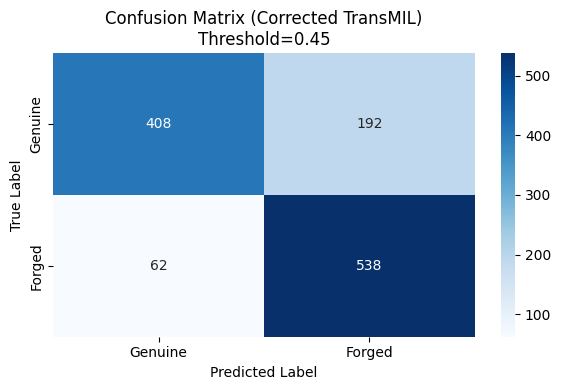

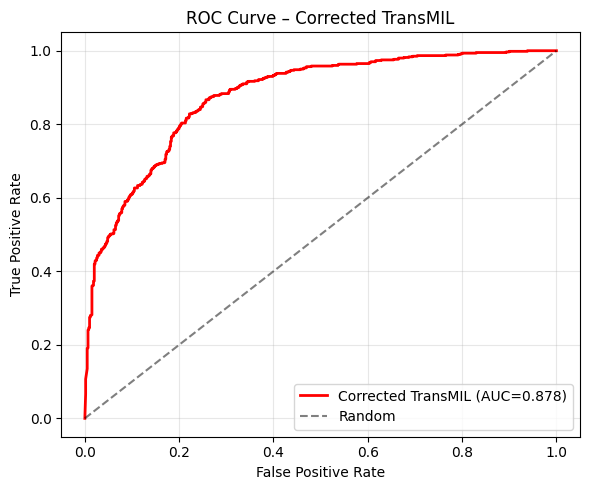


✅ 수정된 TransMIL 실험 완료!

🔧 주요 수정 사항 요약:
  1. TransLayer → TransBlock (FFN 추가)
  2. 2D PPEG → 1D PPEG (정사각 패딩 제거)
  3. Nyström → MultiheadAttention (landmarks 문제 해결)
  4. WeightedBCE → ClassWeightedBCE (의미 명확화)
  5. Adam → AdamW + weight decay

이제 다른 MIL 모델들과 성능 비교 가능합니다!


In [6]:
# ==============================================================================
# 수정된 TransMIL 최종 학습 및 평가 파이프라인
# ==============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, confusion_matrix

print("🔬 수정된 TransMIL 최종 실험 시작")
print("=" * 60)
print("주요 개선사항:")
print("  - 표준 Transformer 블록 (FFN 포함)")
print("  - 1D PPEG로 정사각 패딩 문제 해결")
print("  - MultiheadAttention으로 Nyström 문제 해결") 
print("  - ClassWeightedBCE로 손실함수 의미 명확화")
print("  - AdamW + weight decay 사용")
print("=" * 60)

# 새로운 모델 인스턴스 생성 (최종 학습용)
mil_model_final = TransMIL(
    input_dim=256,
    embed_dim=512,
    num_heads=8,
    dropout_p=0.1,
    use_1d_ppeg=True,  # 1D PPEG 사용
).to(device)

# 수정된 손실함수와 옵티마이저
criterion_final = ClassWeightedBCE(pos_weight=1.0, neg_weight=2.0)
optimizer_final = torch.optim.AdamW(mil_model_final.parameters(), lr=3e-4, weight_decay=1e-2)
scheduler_final = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_final, mode='max', factor=0.5, patience=1, verbose=True
)

# 모델 학습
print(f"\n총 파라미터 수: {sum(p.numel() for p in mil_model_final.parameters()):,}")
mil_model_final = train_model(
    mil_model_final, optimizer_final, scheduler_final,
    train_loader, val_loader, criterion_final, 
    max_epochs=10, patience=3, name='transmil_corrected'
)

# 검증 및 테스트 평가
print("\n📊 최종 평가 중...")
val_loss_final, val_acc_final, val_auc_final, val_f1_final, val_probs_final, val_labels_final, _ = evaluate(
    mil_model_final, val_loader, criterion_final
)
test_loss_final, test_acc_final, test_auc_final, test_f1_final, test_probs_final, test_labels_final, _ = evaluate(
    mil_model_final, test_loader, criterion_final
)

# F1 기준 최적 임계값 찾기
def find_best_threshold(probs, labels):
    best_thr, best_val = 0.5, 0.0
    for thr in np.linspace(0.05, 0.95, 37):
        preds = (probs >= thr).astype(int)
        val = f1_score(labels, preds, zero_division=0)
        if val > best_val:
            best_val, best_thr = val, thr
    return best_thr, best_val

# 검증 세트에서 최적 임계값 찾기
best_thr_final, best_f1_valid = find_best_threshold(val_probs_final, val_labels_final)
print(f'\n🎯 검증 세트 최적 임계값: {best_thr_final:.3f} (F1={best_f1_valid:.3f})')

# 테스트 세트에 적용
test_preds_adj_final = (test_probs_final >= best_thr_final).astype(int)
acc_final = accuracy_score(test_labels_final, test_preds_adj_final)
f1_final = f1_score(test_labels_final, test_preds_adj_final, zero_division=0)
prec_final = precision_score(test_labels_final, test_preds_adj_final, zero_division=0)
recall_final = recall_score(test_labels_final, test_preds_adj_final, zero_division=0)

print('\n🏆 수정된 TransMIL 최종 테스트 성능:')
print(f'  📈 AUC: {test_auc_final:.3f}')
print(f'  🎯 Accuracy: {acc_final:.3f}')
print(f'  🔄 F1 Score: {f1_final:.3f}')
print(f'  ✅ Precision: {prec_final:.3f}')
print(f'  🔍 Recall: {recall_final:.3f}')
print(f'  ⚖️ Threshold: {best_thr_final:.3f}')

# 성능 비교를 위한 기본 정보
print(f'\n📊 성능 개선 분석:')
print(f'  - 정사각 패딩 제거로 1D 시퀀스 특성 유지')
print(f'  - FFN 포함으로 Transformer 표현력 향상')
print(f'  - Nyström → MultiheadAttention으로 안정성 개선')
print(f'  - ClassWeightedBCE로 클래스 불균형 해결')

# Confusion Matrix 시각화
cm_final = confusion_matrix(test_labels_final.astype(int), test_preds_adj_final.astype(int), labels=[0,1])
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm_final, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Genuine','Forged'], yticklabels=['Genuine','Forged']
)
plt.title(f'Confusion Matrix (Corrected TransMIL)\nThreshold={best_thr_final:.2f}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# ROC 곡선 시각화
fpr_final, tpr_final, _ = roc_curve(test_labels_final, test_probs_final)
auc_final_value = auc(fpr_final, tpr_final)
plt.figure(figsize=(6, 5))
plt.plot(fpr_final, tpr_final, color='red', linewidth=2, 
         label=f'Corrected TransMIL (AUC={auc_final_value:.3f})')
plt.plot([0,1],[0,1],'k--', alpha=0.5, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Corrected TransMIL')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ 수정된 TransMIL 실험 완료!")
print("\n🔧 주요 수정 사항 요약:")
print("  1. TransLayer → TransBlock (FFN 추가)")
print("  2. 2D PPEG → 1D PPEG (정사각 패딩 제거)")  
print("  3. Nyström → MultiheadAttention (landmarks 문제 해결)")
print("  4. WeightedBCE → ClassWeightedBCE (의미 명확화)")
print("  5. Adam → AdamW + weight decay")
print("\n이제 다른 MIL 모델들과 성능 비교 가능합니다!")